In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.37'

In [3]:
from fastai import *
from fastai_audio import *
from fastai.vision import models

In [6]:
DATA = Path('data')
NSYNTH_AUDIO = DATA/'nsynth_audio' # contains train and valid folders

In [7]:
!ls {NSYNTH_AUDIO}

models				train_guitar_clean_40_88.csv
test				train_keyboard_clean_21_108.csv
test_guitar_clean_40_88.csv	valid
test_keyboard_clean_21_108.csv	valid_guitar_clean_40_88.csv
train				valid_keyboard_clean_21_108.csv


In [8]:
!ls tmp_labels

test_guitar_clean_40_88.csv	train_keyboard_clean_21_108.csv
test_keyboard_clean_21_108.csv	valid_guitar_clean_40_88.csv
train_guitar_clean_40_88.csv	valid_keyboard_clean_21_108.csv


In [9]:
LABEL_DIR = Path('tmp_labels')
GUITAR_TRN = LABEL_DIR/'train_guitar_clean_40_88.csv'
GUITAR_VAL = LABEL_DIR/'valid_guitar_clean_40_88.csv'
GUITAR_TST = LABEL_DIR/'test_guitar_clean_40_88.csv'

In [10]:
trn_df, val_df, tst_df = [pd.read_csv(CSV) for CSV in [GUITAR_TRN, GUITAR_VAL, GUITAR_TST]]
trn_df.head(2)

,note_str,pitch
0,guitar_acoustic_001-082-050,82
1,guitar_electronic_035-062-127,62


In [11]:
len(trn_df), len(val_df), len(tst_df)

(16915, 1112, 347)

In [12]:
trn_list, val_list, tst_list = [AudioItemList.from_df(df, path=NSYNTH_AUDIO, 
                                                      folder=folder, suffix='.wav')
                                for df, folder in zip([trn_df, val_df, tst_df], 
                                                      ['train', 'valid', 'test'])]
len(trn_list), len(val_list), len(tst_list)

(16915, 1112, 347)

In [13]:
data = (ItemLists(NSYNTH_AUDIO, trn_list, val_list)
            .label_from_df('pitch')
            .add_test(tst_list)
            .databunch())

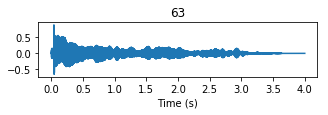

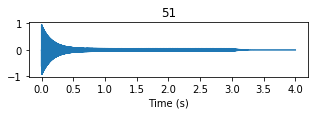

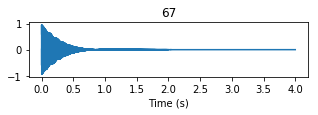

In [15]:
data.show_batch(3)

In [16]:
def first_second(x):
    return x[:16000]

In [18]:
tfm_list = [first_second]
tfms = (tfm_list, tfm_list) # train, valid tfms 

n_fft = 512 
n_hop = 256
n_mels = 64
sample_rate = 16000
ref = 'max'
top_db = 50.0
bs = 32

freq_tfms = get_frequency_batch_transforms(n_fft=n_fft,
                                           n_hop=n_hop,
                                           n_mels=n_mels,
                                           ref=ref,
                                           top_db=top_db,
                                           sample_rate=sample_rate)

data = (ItemLists(NSYNTH_AUDIO, trn_list, val_list)
            .label_from_df('pitch')
            .add_test(tst_list)
            .transform(tfms)
            .databunch(bs=bs, tfms=freq_tfms))
xs, ys = data.one_batch()
xs.shape, ys.shape, xs.min(), xs.max()

(torch.Size([32, 1, 64, 63]), torch.Size([32]), tensor(0.), tensor(1.))

In [19]:
learn = create_cnn(data, models.resnet18, metrics=[accuracy])

In [20]:
model_name = 'pitch_resnet18_v1'
learn.fit_one_cycle(4)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy
1,2.427489,1.357154,0.562050
2,1.431880,0.669867,0.767986
3,1.086307,0.490632,0.834532
4,0.943175,0.448619,0.838130


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


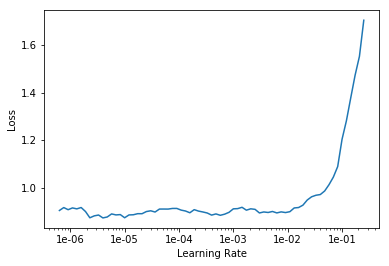

In [21]:
learn.load(model_name + '-stage-1')
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(8, max_lr=1e-3)
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,accuracy
1,0.875541,0.409297,0.848921
2,0.780841,0.342943,0.882194
3,0.654412,0.294415,0.898381
4,0.521151,0.224704,0.923561
5,0.431821,0.229694,0.913669
6,0.351160,0.203001,0.928957
7,0.316230,0.201134,0.936151
8,0.286446,0.195701,0.929856


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


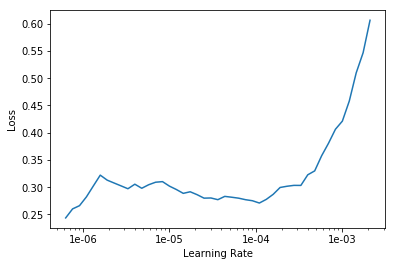

In [25]:
learn.load(model_name + '-stage-2')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.load(model_name + '-stage-2')
learn.fit_one_cycle(8, max_lr=1e-4)
learn.save(model_name + '-stage-3')

epoch,train_loss,valid_loss,accuracy
1,0.296698,0.139229,0.961331
2,0.274744,0.118263,0.959532
3,0.149244,0.033241,0.991906
4,0.113324,0.013875,0.993705
5,0.067162,0.007928,0.997302
6,0.033094,0.002365,1.000000
7,0.016152,0.001230,1.000000
8,0.014174,0.001538,1.000000


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


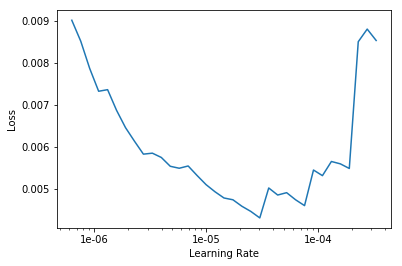

In [27]:
learn.load(model_name + '-stage-3')
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.load(model_name + '-stage-3')
learn.fit_one_cycle(8, max_lr=1e-5)
learn.save(model_name + '-stage-4')

epoch,train_loss,valid_loss,accuracy
1,0.009337,0.001078,1.000000
2,0.014958,0.000928,1.000000
3,0.008576,0.001129,1.000000
4,0.007179,0.001242,1.000000
5,0.009083,0.001012,1.000000
6,0.005978,0.001229,1.000000
7,0.005005,0.001305,0.999101
8,0.004134,0.001105,1.000000


In [31]:
accuracy(*learn.get_preds())

tensor(1.)

In [59]:
n_errors = round(float(1 - accuracy(*learn.get_preds(DatasetType.Train))) * len(trn_list))
print(n_errors, 'errors')

11 errors
